In [1]:
# Install if necessary
pip install tensorflow pydicom numpy scikit-image

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries
import pydicom
import numpy as np
import os
import pylibjpeg
import matplotlib.pyplot as plt
from PIL import Image

# Load DICOM images from directory
def load_dicom_series(directory):
    dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    dicom_files.sort()  # Ensure that files are in the correct order
    
    images = []
    for file in dicom_files:
        dataset = pydicom.dcmread(file)
        images.append(dataset.pixel_array)
    
    return np.stack(images, axis=-1)  # Stack images into a 3D array

# Load images
dicom_directory = 'C:/Users/user/Downloads/series-000001' #사용자가 원하는 디렉토리 설정 가능 
image_series = load_dicom_series(dicom_directory)
images = []

for i in range(image_series.shape[2]):
    image = image_series[:,:,i]
    images.append(image)

"\nplt.figure(figsize=(25,25))\nfor i in range(len(preprocessed_images)):\n    plt.subplot(19,19,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    plt.imshow(preprocessed_images[i], cmap='gray')\nplt.show()\n"

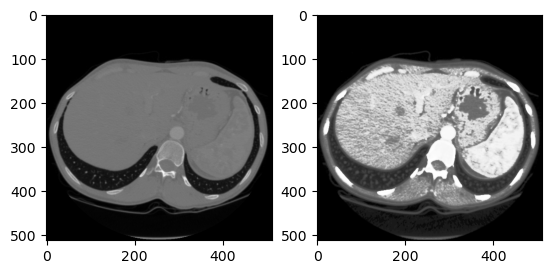

In [60]:
# Pre-process images for better performance
# from skimage.transform import resize
import cv2

def preprocess_images(images):
    # Resize and normalize image
    resized_images = []
    preprocessed_images = []
    
    for i in range(images.shape[2]):
        image = images[:,:,i]

        """
        # Resize (512,512) -> (128,128)
        width = int(image.shape[1] * 25 / 100)
        height = int(image.shape[0] * 25 / 100)
        dim = (width, height)
        resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_image)
        """

        # Normalize [0,1]
        #image = resized_images[i]
        image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image = image.astype(np.uint8)

        # Gaussian blur
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # Histogram equalization
        image = cv2.equalizeHist(image)
        
        preprocessed_images.append(image)
        
    return preprocessed_images

# Pre-process images
preprocessed_images = preprocess_images(image_series)

"""
plt.subplot(1,2,1)
plt.imshow(images[0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(preprocessed_images[0], cmap='gray')

plt.figure(figsize=(25,25))
for i in range(len(preprocessed_images)):
    plt.subplot(19,19,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preprocessed_images[i], cmap='gray')
plt.show()
"""

In [59]:
# Edge detection
edges = []
for i in range(len(preprocessed_images)):
    #_, otsu_threshold = cv2.threshold(preprocessed_images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edge = cv2.Canny(preprocessed_images[i], 100, 200)
    edges.append(edge)

# Overlay detected edges onto images
overlayed_images = []

def overlay_edges(preprocessed_images, edges):
    for img, edge in zip(preprocessed_images, edges):
        rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        color = [0,255,0] # 사용자가 설정 가능하게 

        color_edges = np.zeros_like(rgb_image, dtype=np.uint8)

        color_edges[edge > 0] = color

        overlayed_image = cv2.addWeighted(rgb_image, 1, color_edges, 1, 0)
        overlayed_images.append(overlayed_image)
        
    return np.array(overlayed_images)

overlayed_images = overlay_edges(preprocessed_images, edges)

# Save images to directory
def save_images(overlayed_images, folder_path, file_prefix = 'edges'): 
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i in range(len(overlayed_images)):
        overlayed_image = overlayed_images[i]
        # Convert to PIL Image
        pil_image = Image.fromarray(overlayed_image)
        
        # Define file path and save image
        file_path = os.path.join(folder_path, f"{file_prefix}_{i}.png") # prefix는 기능마다 자동으로 다르게 설정되게 if else if
        pil_image.save(file_path)

folder_path = 'C:/Users/user/Downloads/edges' # 사용자가 설정 가능
save_images(overlayed_images, folder_path)  

In [102]:
"""
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
"""    

In [ ]:
# Provide annotated images intended for masks 
# Use cornerstonejs to manually annotate Regions of Interest (RoI)
"""
import numpy as np
from PIL import Image
import os

def load_annotation(annotation_path):
    """Load annotated image and convert to binary mask."""
    annotation_image = Image.open(annotation_path)
    mask = np.array(annotation_image)
    
    # Convert to binary mask (assuming white is the mask)
    binary_mask = (mask > 0).astype(np.uint8)
    
    return binary_mask
"""

"""
from skimage.transform import resize

def resize_mask(mask, target_size):
    """Resize mask to target size."""
    return resize(mask, target_size, mode='constant', preserve_range=True, anti_aliasing=True)
"""

"""
import pydicom

def apply_mask_to_dicom(dicom_path, mask):
    """Apply mask to a DICOM image."""
    dataset = pydicom.dcmread(dicom_path)
    image = dataset.pixel_array
    
    # Apply mask
    masked_image = np.where(mask > 0, image, 0)
    
    return masked_image
"""

"""
def save_mask_as_dicom(mask, output_path):
    """Save binary mask as a DICOM file."""
    mask_dicom = pydicom.Dataset()
    mask_dicom.PixelData = mask.tobytes()
    mask_dicom.Rows, mask_dicom.Columns = mask.shape
    mask_dicom.SOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    mask_dicom.SOPInstanceUID = pydicom.uid.generate_uid()
    mask_dicom.file_meta = pydicom.FileMetaDataset()
    mask_dicom.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

    # Save to file
    pydicom.dcmwrite(output_path, mask_dicom)
"""

"""
import os

# Paths to your data
dicom_path = 'path/to/dicom/file.dcm'
annotation_path = 'path/to/annotation/image.png'
output_path = 'path/to/output/mask.dcm'

# Load and preprocess annotation
binary_mask = load_annotation(annotation_path)

# Resize mask if needed (example target size should match DICOM image)
target_size = (512, 512)  # Update this to match your DICOM image size
resized_mask = resize_mask(binary_mask, target_size)

# Apply mask to DICOM image (if needed)
masked_image = apply_mask_to_dicom(dicom_path, resized_mask)

# Save mask as DICOM file
save_mask_as_dicom(resized_mask, output_path)

print("Mask created and saved successfully.")
"""